In [1]:
#!/usr/bin/env python
from __future__ import print_function

import tensorflow as tf
import sys
sys.path.append("game/")
import wrapped_flappy_bird as game
import random
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
import matplotlib.cm as cm

ACTIONS = 2 # number of valid actions
GAMMA = 0.99 # decay rate of past observations
OBSERVE = 1000. # timesteps to observe before training
EXPLORE = 2000000. # frames over which to anneal epsilon
FINAL_EPSILON = 0.0001 # final value of epsilon
INITIAL_EPSILON = 0.1 # starting value of epsilon
REPLAY_MEMORY = 1000 # number of previous transitions to remember
BATCH = 128 # size of minibatch


In [2]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev = 0.01)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.01, shape = shape)
    return tf.Variable(initial)

def conv2d(x, W, stride):
    return tf.nn.conv2d(x, W, strides = [1, stride, stride, 1], padding = "SAME")

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = "SAME")

In [3]:
#create model
W_conv1 = weight_variable([8, 8, 4, 32])
b_conv1 = bias_variable([32])

W_conv2 = weight_variable([4, 4, 32, 64])
b_conv2 = bias_variable([64])

W_conv3 = weight_variable([3, 3, 64, 64])
b_conv3 = bias_variable([64])

W_fc1 = weight_variable([1600, 512])
b_fc1 = bias_variable([512])

W_fc2 = weight_variable([512, ACTIONS])
b_fc2 = bias_variable([ACTIONS])


# input layer
s = tf.placeholder("float", [None, 80, 80, 4])

# hidden layers
h_conv1 = tf.nn.relu(conv2d(s, W_conv1, 4) + b_conv1) ### ===> 80x80x4 conv 4 ==> 20x20x32
h_pool1 = max_pool_2x2(h_conv1)                       ### ===> 20x20x32 maxpool => 10x10x64

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2, 2) + b_conv2) ###=====10x10 conv2 ===>5x5x64
#h_pool2 = max_pool_2x2(h_conv2)

h_conv3 = tf.nn.relu(conv2d(h_conv2, W_conv3, 1) + b_conv3) ## 5x5 conv 1 padsame =>5x5x64
#h_pool3 = max_pool_2x2(h_conv3)

#h_pool3_flat = tf.reshape(h_pool3, [-1, 256]) 
h_conv3_flat = tf.reshape(h_conv3, [-1, 1600])               ##5x5x64 flaten =>1600

h_fc1 = tf.nn.relu(tf.matmul(h_conv3_flat, W_fc1) + b_fc1)

# readout layer
readout = tf.matmul(h_fc1, W_fc2) + b_fc2

In [4]:
# define the cost function
a = tf.placeholder("float", [None, ACTIONS])
y = tf.placeholder("float", [None])

readout_action = tf.reduce_sum(tf.multiply(readout, a), reduction_indices=1)
cost = tf.reduce_mean(tf.square(y - readout_action)) #rms root mean square for cost function
train_step = tf.train.AdamOptimizer(1e-6).minimize(cost)

# open up a game state to communicate with emulator
game_state = game.GameState()

# store the previous observations in replay memory
D = deque()

# saving and loading networks
saver = tf.train.Saver()
checkpoint = tf.train.get_checkpoint_state("saved_networks")
#if checkpoint and checkpoint.model_checkpoint_path:
#    saver.restore(sess, checkpoint.model_checkpoint_path)
#    print("Successfully loaded:", checkpoint.model_checkpoint_path)
#else:
#    print("Could not find old network weights")


In [5]:
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

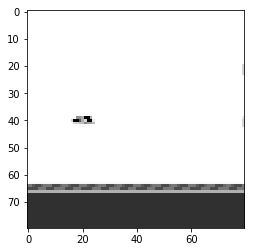

(80, 80, 4)
Test readout : 
[ 0.04237654  0.01803758]
Test cost : 0.4594


In [6]:
def prepare_img(x_t):
    x_t = tf.image.rgb_to_grayscale(x_t)
    x_t = tf.image.resize_images(x_t,[80,80])
    return x_t.eval()

########### TEST Play ################
# get the first state by doing nothing and preprocess the image to 80x80x4
do_nothing = np.zeros(ACTIONS)
do_nothing[0] = 1
x_t, r_0, terminal = game_state.frame_step(do_nothing)
x_t = prepare_img(x_t)
######################################
# show image
imtest = np.array(x_t)
plt.imshow(np.reshape(x_t,[80,80]).T,cmap=cm.Greys)
plt.show()
#####################################
s_t = np.stack((x_t, x_t, x_t, x_t), axis=2).reshape([80,80,4])
print(s_t.shape)
############# TEST FEEDING ##########
read = readout.eval(feed_dict={s : [s_t]})[0]
print("Test readout : ")
print(read)
a_t = np.zeros([ACTIONS])
a_t[0] = 1
print("Test cost : %.4f" % cost.eval(feed_dict={s : [s_t], a : [a_t], y: a_t}))
#####################################


In [8]:
def get_stage(s_t,a_t):
    # run the selected action and observe next state and reward
    x_t1_colored, r_t, terminal = game_state.frame_step(a_t)
    x_t1 = prepare_img(x_t1_colored)
    x_t1 = np.reshape(x_t1, (80, 80, 1))    
    #s_t1 = np.append(x_t1, s_t[:,:,1:], axis = 2)
    s_t1 = np.append(x_t1, s_t[:, :, :3], axis=2)
    return s_t1, r_t, terminal

In [9]:
def play_action(epsilon,readout_t):
    a_t = np.zeros([ACTIONS])
    action_index = 0
    if random.random() <= epsilon:
        print("----------Random Action----------")
        action_index = random.randrange(ACTIONS)
        a_t[random.randrange(ACTIONS)] = 1
    else:
        action_index = np.argmax(readout_t)
        a_t[action_index] = 1
    #maybe skip some frame with a_t[0] = 1 # do nothing
    return a_t,action_index

In [10]:
# start training
epsilon = INITIAL_EPSILON
rp = 0
while len(D) < REPLAY_MEMORY:
    
    # choose an action epsilon greedily
    readout_t = readout.eval(feed_dict={s : [s_t]})[0]
    a_t,action_index = play_action(epsilon,readout_t)
    
    ######### play ! ########
    s_t1,r_t,terminal = get_stage(s_t,a_t)
    
    # store the transition in D
    D.append((s_t, a_t, r_t, s_t1, terminal))
    
    s_t = s_t1
    rp += 1
    if(rp % 100 == 0):
        print("TRY PLAY and RECORD : %d max readout %.4f" % (rp,np.max(readout_t)))

----------Random Action----------
----------Random Action----------
----------Random Action----------
----------Random Action----------
----------Random Action----------
----------Random Action----------
----------Random Action----------
----------Random Action----------
----------Random Action----------
----------Random Action----------
----------Random Action----------
TRY PLAY and RECORD : 100 max readout 0.0461
----------Random Action----------
----------Random Action----------
----------Random Action----------
----------Random Action----------
----------Random Action----------
----------Random Action----------
----------Random Action----------
----------Random Action----------
----------Random Action----------
----------Random Action----------
----------Random Action----------
TRY PLAY and RECORD : 200 max readout 0.0418
----------Random Action----------
----------Random Action----------
----------Random Action----------
----------Random Action----------
----------Random Action---

In [13]:
# start training
# choose an action epsilon greedily
readout_t = readout.eval(feed_dict={s : [s_t]})[0]
a_t,action_index = play_action(epsilon,readout_t)

# scale down epsilon
if epsilon > FINAL_EPSILON:
    epsilon -= (INITIAL_EPSILON - FINAL_EPSILON) / EXPLORE

# run the selected action and observe next state and reward
s_t1,r_t,terminal = get_stage(s_t,a_t)
# store the transition in D
D.append((s_t, a_t, r_t, s_t1, terminal))

if len(D) > REPLAY_MEMORY:
    D.popleft()
# sample a minibatch to train on
minibatch = random.sample(D, BATCH)

# get the batch variables
s_j_batch = [d[0] for d in minibatch]
a_batch = [d[1] for d in minibatch]
r_batch = [d[2] for d in minibatch]
s_j1_batch = [d[3] for d in minibatch]

y_batch = []
readout_j1_batch = readout.eval(feed_dict = {s : s_j1_batch})
for i in range(0, len(minibatch)):
    terminal = minibatch[i][4]
    # if terminal, only equals reward
    if terminal:
        y_batch.append(r_batch[i])
    else:
        y_batch.append(r_batch[i] + GAMMA * np.max(readout_j1_batch[i]))

# perform gradient step
train_step.run(feed_dict = {
    y : y_batch,
    a : a_batch,
    s : s_j_batch}
)

# update the old values
s_t = s_t1
rp += 1

# save progress every 10000 iterations
if rp % 10000 == 0:
    saver.save(sess, 'saved_networks/dqn', global_step = rp)
if rp % 1 == 0:
    print("TIMESTEP", rp, "/ STATE explore / EPSILON", epsilon, "/ ACTION", action_index, "/ REWARD", r_t, \
        "/ Q_MAX %e" % np.max(readout_t))    

----------Random Action----------
TIMESTEP 1003 / STATE explore / EPSILON 0.09999985015000001 / ACTION 1 / REWARD 0.1 / Q_MAX 3.340925e-02
